In [ ]:
# Setup for Google Colab 
!git clone https://github.com/KJ-rc/spatialrgpt-tutorial.git /content/repo
%cd /content/repo
!pip install -r requirements.txt --progress-bar off --quiet
! cd datasets && bash download_datasets.sh 
!pip install "git+https://github.com/KJ-rc/aisuite.git"

# Simple Guide to Spatial Reasoning Evaluation

This notebook introduces **SpatialRGPT**, a recent formal study that addresses important and advanced image understanding problems, specifically spatial reasoning questions. 


Instead of testing hundreds of examples at once, this script lets you:
- **Test one example at a time** - Perfect for learning and debugging
- **Get automatic scoring** - No manual checking needed
- **Use different AI models** - Compare GPT, Gemini, etc.

## Simple Workflow

```
📥 Input: One image + question (+ a few Q&A examples)
    ↓
🔄 Processing: AI model analyzes the image
    ↓  
📊 Output: Answer (+ automatic evaluation score)
```

## 1. Library Imports

Import the evaluation modules and configure path settings to access the evaluation scripts properly.

### 🔑 Setting up API Keys (Google Colab Users)

If you're running this in Google Colab, you'll need to set up your API keys using Colab's secrets feature:

1. **Add Secrets in Colab:**
   - Click the 🔑 key icon in the left sidebar
   - Add these secrets:
     - `OPENAI_API_KEY` - Your OpenAI API key
     - `GOOGLE_API_KEY` - Your Google/Gemini API key

2. **Enable Access:** Toggle the notebook access for each secret you add.

**🔒 Security Note:** Secrets are securely stored with your Google account, not in this notebook. This prevents your API keys from being accidentally shared or exposed when sharing notebooks - a much safer approach than hardcoding keys in cells.


In [ ]:
# Set Google API Key from Colab secrets
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
# os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Environment setup and library imports
import sys
import warnings
import json
from pathlib import Path

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="requests")
warnings.filterwarnings("ignore", message="Unable to find acceptable character detection dependency")

# Add project paths
sys.path.insert(0, os.path.join(os.getcwd(), 'aisuite'))


# Import required packages
import aisuite as ai
from PIL import Image
from dotenv import load_dotenv
from batch_evaluator import load_image, create_messages

# Load environment variables
load_dotenv()

print("✅ Environment ready!")
print("✅ Libraries loaded")

✅ Environment ready!
✅ Libraries loaded


## 2. Dataset Loading and Sample Exploration

Load spatial reasoning test datasets with overlay images for evaluation.
Explore sample data structure to understand the input format for single-example processing.

📥 Input: Loaded 3 sample questions

📝 Example Question: Who is lower down, Region [0] or Region [1]?
🎯 Expected Answer: Region [1] is below.

📝 Example Question: Who is lower down, Region [0] or Region [1]?
🎯 Expected Answer: Region [1] is below.


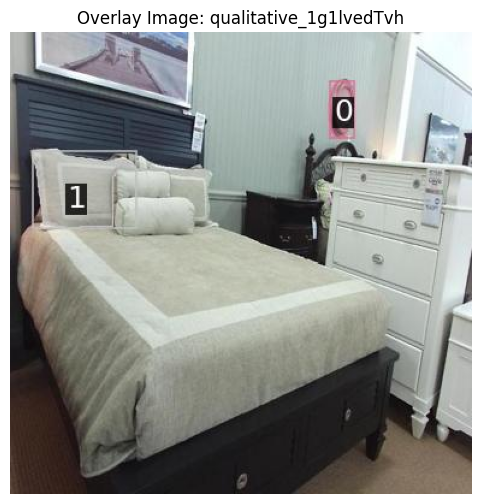

🎨 Overlay image loaded: .overlay/0000035_overlay.jpg


In [2]:
# Load sample data
annotation_file = "datasets/spatial_category_subsets/below_above_subset.jsonl"

questions = []
with open(annotation_file) as f:
    for line in f:
        questions.append(json.loads(line.strip()))
        if len(questions) >= 3:  # Just load 3 examples
            break

print(f"📥 Input: Loaded {len(questions)} sample questions")

# Show example with overlay image
from PIL import Image
import matplotlib.pyplot as plt

sample = questions[0]
print(f"\n📝 Example Question: {sample['text_q']}")
print(f"🎯 Expected Answer: {sample['conversations'][1]['value']}")

# Display the overlay image (the one actually used by the model)
overlay_path = sample.get('overlay')
if overlay_path and os.path.exists(overlay_path):
    img = Image.open(overlay_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Overlay Image: {sample['id']}")
    plt.show()
    print(f"🎨 Overlay image loaded: {overlay_path}")
else:
    print(f"🎨 Overlay path: {overlay_path} (image may not be available)")

## 3. Single Example Processing Pipeline & Demo

Demonstrate the core pipeline for processing single images through spatial reasoning evaluation.
Show how the script selects and prepares individual examples for LLM inference.

In [3]:
# Demonstrate single example processing pipeline
example_index = 0
selected_example = questions[example_index]

print(f"🎯 Processing Example {example_index}: {selected_example['id']}")
print("="*60)

# Meta information
question_id = selected_example["id"]
image_file = selected_example["image_info"]["file_path"]
text_question = selected_example["text_q"]
qa_info = selected_example["qa_info"]
ground_truth = selected_example["conversations"][1]["value"]
overlay_path = selected_example.get("overlay")

print(f"📋 Question: {text_question}")
print(f"📊 Type: {qa_info['type']} ({qa_info['category']})")
print(f"🎯 Ground Truth: {ground_truth}")
print(f"🖼️  Image: {image_file}")

# Show message structure that would be created
print(f"\n📤 Message Structure Preview:")
print(f"  • System: Instructions for spatial reasoning")
print(f"  • User: '{text_question[:50]}...' + [IMAGE]")
print(f"  • Expected: LLM response about spatial relationships")

🎯 Processing Example 0: qualitative_1g1lvedTvh
📋 Question: Who is lower down, Region [0] or Region [1]?
📊 Type: qualitative (below_choice)
🎯 Ground Truth: Region [1] is below.
🖼️  Image: SUNRGBD/kv2/kinect2data/001758_2014-06-26_19-53-49_260595134347_rgbf000035-resize/image/0000035.jpg

📤 Message Structure Preview:
  • System: Instructions for spatial reasoning
  • User: 'Who is lower down, Region [0] or Region [1]?...' + [IMAGE]
  • Expected: LLM response about spatial relationships


In [ ]:
# Demo: Run a live example
print("🚀 Live Demo: Running Example with AI Model")
print("="*50)

# Use the first example and a fast model for demo
demo_example = questions[0]
model_name = "google:gemini-2.5-flash"  # Fast and reliable

print(f"📝 Question: {demo_example['text_q']}")
print(f"🎯 Expected: {demo_example['conversations'][1]['value']}")
print(f"🤖 Model: {model_name}")

# Initialize the AI client
client = ai.Client()

# Load the overlay image
overlay_path = demo_example.get('overlay')
image = load_image(overlay_path)

# Create messages for the model
messages = create_messages(demo_example['text_q'], image, model_name)

print(f"\n🔄 Processing... (this may take a few seconds)")

# Make API call
response = client.chat.completions.create(
    model=model_name,
    messages=messages,
    max_tokens=150,
    temperature=0.0
)

model_answer = response.choices[0].message.content.strip()

print(f"\n✅ Model Response:")
print(f"📤 AI Answer: {model_answer}")



🚀 Live Demo: Running Example with AI Model
📝 Question: Who is lower down, Region [0] or Region [1]?
🎯 Expected: Region [1] is below.
🤖 Model: google:gemini-2.5-flash

🔄 Processing... (this may take a few seconds)

✅ Model Response:
📤 AI Answer: Region [1] is lower down than Region [0].

✅ Model Response:
📤 AI Answer: Region [1] is lower down than Region [0].


## 4. Upload & Test Your Own Image

Upload your own image and ask custom spatial reasoning questions. 
This lets you experiment with the AI model on your own examples before testing on the benchmark datasets.

In [ ]:
from google.colab import files
from IPython.display import display, Image as DisplayImage # Alias IPython Image to avoid conflict
import io
from PIL import Image # Import PIL Image

print("📤 Please upload a single image:")
uploaded = files.upload()

# Get the uploaded file (first/only one)
uploaded_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded: {uploaded_filename}")

# Load image using PIL to get size
image_bytes = uploaded[uploaded_filename]
pil_image = Image.open(io.BytesIO(image_bytes))

# Display image using IPython.display.Image
display_image = DisplayImage(image_bytes)
display(display_image)

print(f"📐 Size: {pil_image.size}")

In [ ]:
# Ask your custom question using @param
custom_question = "Enter your spatial reasoning question" #@param {type:"string"}
model_name = "google:gemini-2.5-flash"

print(f"\n📝 Question: {custom_question}")
print(f"🤖 Model: {model_name}")
print(f"🔄 Processing...")

if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')

messages = create_messages(custom_question, pil_image, model_name)

# API call
response = client.chat.completions.create(
    model=model_name,
    messages=messages,
    max_tokens=150,
    temperature=0.0
)

custom_answer = response.choices[0].message.content.strip()
print(f"\n✅ AI Answer: {custom_answer}")

## 5. Automatic Evaluation System

The SpatialRGPT framework defines three comprehensive evaluation modes for spatial reasoning: quantitative direction, distance/size, and qualitative spatial relationships. This systematic approach enables rigorous assessment of AI models' spatial understanding capabilities.

See how the system automatically scores AI responses with a live evaluation demo based on this research framework.

In [5]:
# Three Question Types and Evaluation Methods
print("🎯 SpatialEvaluator: Three Question Types")
print("="*50)

# Show the three different question types from our loaded examples
print("📋 Examples loaded in prev section:")
for i, q in enumerate(questions[:3]):
    print(f"  {i+1}. {q['qa_info']['type'].title()} ({q['qa_info']['category']})")
    print(f"     Q: {q['text_q'][:60]}...")
    print(f"     A: {q['conversations'][1]['value'][:40]}...")
    print()

# Evaluation methods overview
evaluation_methods = {
    "quantitative_direction": {
        "description": "Clock positions (12 o'clock system)",
        "threshold": "≤1 hour → CORRECT",
        "example": "GT: 10 o'clock, Pred: 9 o'clock → CORRECT"
    },
    "quantitative_distance": {
        "description": "Distances/sizes with unit conversion",
        "threshold": "≤25% error → ACCURATE", 
        "example": "GT: 30 inches, Pred: 36 inches → ACCURATE"
    },
    "qualitative": {
        "description": "Spatial relationships correctness",
        "threshold": "Semantic match → CORRECT",
        "example": "GT: 'No', Pred: 'No' → CORRECT"
    }
}

print("📊 Evaluation Methods & Scoring:")
for method, details in evaluation_methods.items():
    print(f"🔸 {method.replace('_', ' ').title()}: {details['description']}")
    print(f"   Threshold: {details['threshold']}")

print("\n" + "="*50)
print("🚀 Live Evaluation Demo")
print("="*50)

# Demo with actual evaluation - reuse the AI response from section 3
demo_q = questions[0]
print(f"📝 Question: {demo_q['text_q']}")
print(f"🎯 Ground Truth: {demo_q['conversations'][1]['value']}")

# Use the model_answer from the previous demo (section 3)
demo_response = model_answer
print(f"🤖 AI Response (from prev section): {demo_response}")

# Determine evaluation type
qa_info = demo_q["qa_info"]
if qa_info["type"] == "qualitative":
    eval_type = "qualitative"
elif qa_info["type"] == "quantitative" and "direction" in qa_info["category"]:
    eval_type = "quantitative_direction"
elif qa_info["type"] == "quantitative":
    eval_type = "quantitative_distance"
else:
    eval_type = "unknown"

print(f"🔍 Detected Type: {eval_type}")
print(f"🔄 Running evaluation...")

# Demo with actual evaluation
from single_evaluator import SpatialEvaluator
evaluator = SpatialEvaluator("google:gemini-2.5-flash")

result = evaluator.evaluate_qualitative(question=demo_q['text_q'],
                                        answer=demo_q['conversations'][1]['value'],
                                        response=demo_response)

🎯 SpatialEvaluator: Three Question Types
📋 Examples loaded in prev section:
  1. Qualitative (below_choice)
     Q: Who is lower down, Region [0] or Region [1]?...
     A: Region [1] is below....

  2. Qualitative (below_predicate)
     Q: Does Region [0] appear under Region [1]?...
     A: Yes, Region [0] is below Region [1]....

  3. Qualitative (above_choice)
     Q: Between Region [0] and Region [1], which one is positioned h...
     A: Region [1] is above....

📊 Evaluation Methods & Scoring:
🔸 Quantitative Direction: Clock positions (12 o'clock system)
   Threshold: ≤1 hour → CORRECT
🔸 Quantitative Distance: Distances/sizes with unit conversion
   Threshold: ≤25% error → ACCURATE
🔸 Qualitative: Spatial relationships correctness
   Threshold: Semantic match → CORRECT

🚀 Live Evaluation Demo
📝 Question: Who is lower down, Region [0] or Region [1]?
🎯 Ground Truth: Region [1] is below.
🤖 AI Response (from prev section): Region [1] is lower down than Region [0].
🔍 Detected Type: qualit

[DEBUG] Qualitative evaluation response: {
  "status": "correct",
  "explanation": "Both the answer and the response correctly identify Region [1] as being lower down or below Region [0]."
}


## 6. Running the Full Benchmark

Now let's run the actual benchmark script on a **focused debug dataset** using `batch_evaluator.py`, which processes all examples in batch mode.

Our focused dataset contains **120 carefully selected examples** covering only **above/below spatial relationships**:
- **below_choice**: 19 examples
- **below_predicate**: 35 examples  
- **above_choice**: 29 examples
- **above_predicate**: 37 examples

This gives us a clean demonstration of qualitative spatial reasoning evaluation.

In [ ]:
# Run the benchmark script on entire debug dataset
print("🚀 Running eval_spatial_simple.py on entire debug dataset")
print("="*55)

# Count total examples first
with open("datasets/spatial_category_subsets/below_above_subset.jsonl") as f:
    total_examples = sum(1 for _ in f)

print(f"📊 Debug dataset has {total_examples} examples")
print("🤖 Using google:gemini-2.5-flash model")
print("🎯 Processing ALL examples in batch mode")
print()

# Step 1: Run eval_spatial_simple.py which processes the entire dataset
print("Step 1: Generating AI responses...")
get_ipython().system('python -W ignore -m batch_evaluator --annotation-file datasets/spatial_category_subsets/below_above_subset.jsonl --model google:gemini-2.5-flash --output-path ./eval_output/below_above_results')


print(f"\n✅ Responses saved to ./eval_output/below_above_results/responses_with_predictions.jsonl")

# Step 2: Evaluate the responses using evaluate_spatial_unified.py
print(f"\nStep 2: Evaluating responses with LLM-as-a-judge...")
get_ipython().system('python llm_judge_scorer.py ./eval_output/below_above_results/responses_with_predictions.jsonl google:gemini-2.5-flash')

print(f"\n✅ Complete Pipeline:")
print(f"   1. eval_spatial_simple.py → Generates AI responses for all examples")
print(f"   2. evaluate_spatial_unified.py → Evaluates responses & calculates success rates")

🚀 Running eval_spatial_simple.py on entire debug dataset
📊 Debug dataset has 120 examples
🤖 Using google:gemini-2.5-flash model
🎯 Processing ALL examples in batch mode

Step 1: Generating AI responses...

✅ Responses saved to ./eval_output/focused_debug_results/responses_with_predictions.jsonl

Step 2: Evaluating responses with LLM-as-a-judge...
Using model: openai:gpt-5-nano
Evaluating: ./eval_output/focused_debug_results/responses_with_predictions.jsonl
Total samples: 120
Processing samples: 100%|█████████████████████| 120/120 [05:51<00:00,  2.93s/it]

EVALUATION RESULTS

Qualitative Results:
below/above: 77.50%

Quantitative Results:

Overall Statistics:
Qualitative Overall: 77.50%
N/A
Match Failures: 8

Results saved to: ./eval_output/focused_debug_results/score.json
Raw data saved to: ./eval_output/focused_debug_results/raw_evaluation.json

✅ Complete Pipeline:
   1. eval_spatial_simple.py → Generates AI responses for all examples
   2. evaluate_spatial_unified.py → Evaluates resp

## 7. Next Steps: Experimentation Guide

Now that you understand the basic pipeline, here are ways to experiment and extend your spatial reasoning evaluation:

### 🚀 **Try Different AI Models**
*Available AI Models (2025)*

Here are the latest models you can test with their representative features:

| Provider | Model | Key Features |
|----------|-------|-------------|
| **OpenAI** | `openai:gpt-4o` | Stable performance, widely tested |
| | `openai:gpt-5` | Latest flagship model |
| | `openai:gpt-5-mini` | Fast inference, cost-effective |
| | `openai:gpt-5-nano` | Ultra-fast responses, lightweight |
| **Google** | `google:gemini-2.5-flash` | Latest version, optimized speed |
| | `google:gemini-2.0-flash-exp` | Earlier experimental version |
| **Nebius** | `nebius:qwen-2-vl-72b` | Large parameter count, multilingual |
| | `nebius:qwen-2-vl-7b` | Smaller size, efficient processing |



Start with a single example to test quickly:
```bash
# Test different models on one example
python single_evaluator.py --annotation-file datasets/spatial_category_subsets/below_above_subset.jsonl --example-index 0 --model openai:gpt-4o
python single_evaluator.py --annotation-file datasets/spatial_category_subsets/below_above_subset.jsonl --example-index 0 --model openai:gpt-5-mini
python single_evaluator.py --annotation-file datasets/spatial_category_subsets/below_above_subset.jsonl --example-index 0 --model google:gemini-2.0-flash-exp
```


### 📊 **Try Different Categories**

**New!** We've created 12 category-specific subsets available in `spatial_category_subsets.zip`:

| Category Type | Category | Examples | File |
|---------------|----------|----------|------|
| **Qualitative** | Below/Above | 120 | `below_above_subset.jsonl` |
| | Left/Right | 105 | `left_right_subset.jsonl` |
| | Big/Small | 106 | `big_small_subset.jsonl` |
| | Tall/Short | 112 | `tall_short_subset.jsonl` |
| | Wide/Thin | 104 | `wide_thin_subset.jsonl` |
| | Behind/Front | 110 | `behind_front_subset.jsonl` |
| **Quantitative** | Direct Distance | 376 | `direct_distance_subset.jsonl` |
| | Horizontal Distance | 122 | `horizontal_distance_subset.jsonl` |
| | Vertical Distance | 106 | `vertical_distance_subset.jsonl` |
| | Width | 133 | `width_subset.jsonl` |
| | Height | 133 | `height_subset.jsonl` |
| | Direction | 107 | `direction_subset.jsonl` |

**Example Usage:**
```bash
# Test spatial relationships (qualitative)
python batch_evaluator.py --annotation-file spatial_category_subsets/below_above_subset.jsonl --model google:gemini-2.5-flash --output-path ./eval_output/below_above_results

# Test distance measurements (quantitative, largest category)
python batch_evaluator.py --annotation-file spatial_category_subsets/direct_distance_subset.jsonl --model openai:gpt-4o --output-path ./eval_output/direct_distance_results

# Test directional reasoning (quantitative)  
python batch_evaluator.py --annotation-file spatial_category_subsets/direction_subset.jsonl --model openai:gpt-4o --output-path ./eval_output/direction_results
```

### ✏️ **Try Different Prompts**

There are **two types of prompts** you can modify:

#### **1. System Prompt (Global Instructions)**
The **system prompt** provides overall instructions to the AI model and is used for ALL examples. To modify it:

**Location:** Edit the `SYSTEM_PROMPT` variable in `batch_evaluator.py` (around lines 15-30)

**Current system prompt:**
```
"You are an intelligent question-answering agent. I will ask you questions about spatial information regarding a scene, and you must provide an answer..."
```

**How to modify:**
```bash
# 1. Backup the original
cp batch_evaluator.py batch_evaluator_backup.py

# 2. Edit the file (use VS Code, nano, or vim)
code batch_evaluator.py

# 3. Find SYSTEM_PROMPT variable and change it to your version:
SYSTEM_PROMPT = "You are a precise spatial reasoning expert. Analyze images carefully and provide exact measurements and relationships."

# 4. Save and run evaluation
python batch_evaluator.py --annotation-file spatial_category_subsets/below_above_subset.jsonl --model google:gemini-2.5-flash --output-path ./eval_output/custom_system_prompt
```

#### **2. Individual Question Prompts (Per Example)**
Each question has its own **specific prompt** that gets combined with the system prompt. These are stored in the **`text_q` field** of each example in the JSONL files.

**Location:** Each line in the dataset files contains a `text_q` field like:
```json
{"text_q": "Who is lower down, Region [0] or Region [1]?", ...}
```

**To modify individual prompts, you would need to edit the JSONL files directly:**
```bash
# Example: Create custom question phrasings for a small test
head -5 spatial_category_subsets/below_above_subset.jsonl > custom_questions.jsonl
# Edit custom_questions.jsonl to modify the "text_q" fields
python batch_evaluator.py --annotation-file custom_questions.jsonl --model google:gemini-2.5-flash --output-path ./eval_output/custom_questions
```

### 🔬 **Systematic Experimentation**

**Progressive Testing Strategy:**
1. **Single Example (30 seconds)**: Test idea quickly
2. **Small Batch (~10 examples, 2-3 minutes)**: Validate approach  
3. **Category Subset (~100-400 examples, 5-15 minutes)**: Test specific reasoning type
4. **Full Dataset (1,406 examples, > 1 hour, varies by model)**: Get comprehensive results

**Example Workflow:**
```bash
# 1. Quick test
python single_evaluator.py --annotation-file spatial_category_subsets/below_above_subset.jsonl --example-index 5 --model your-model

# 2. Small validation (first 10 examples)
head -10 spatial_category_subsets/below_above_subset.jsonl > small_test.jsonl
python batch_evaluator.py --annotation-file small_test.jsonl --model your-model --output-path ./eval_output/small_test

# 3. Category evaluation (full category)
python batch_evaluator.py --annotation-file spatial_category_subsets/below_above_subset.jsonl --model your-model --output-path ./eval_output/category_test

# 4. Full evaluation (all 1,406 examples)
python batch_evaluator.py --annotation-file SpatialRGPT-Bench_v1_with_overlay.json --model your-model --output-path ./eval_output/full_test
```

### 📈 **Compare Results**

Use JSON comparison to track improvements:
```bash
# Compare different model results
python -c "
import json
with open('./eval_output/model1/score.json') as f: m1 = json.load(f)
with open('./eval_output/model2/score.json') as f: m2 = json.load(f)
print(f'Model 1: {m1[\"Qual_overall_acc\"]:.1f}%')
print(f'Model 2: {m2[\"Qual_overall_acc\"]:.1f}%')
"
```

**Happy experimenting! 🚀**